In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import site
site.addsitedir('../../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
img_dir = "../../../Data/TrainingData/AR-UNet/BAMC-PTX*Sliding-Annotations-Linear/"

all_images = sorted(glob(os.path.join(img_dir, '*_?????.mha')))
all_labels = sorted(glob(os.path.join(img_dir, '*.extruded-overlay.mha')))

num_images = len(all_images)
num_labels = len(all_labels)
print(num_images, num_labels)

val_images = []
val_labels = []
train_images = []
train_labels = []
for i in range(num_images):
    if i%8 == 0 or (i%2 == 0 and i<num_images/2):
        val_images.append(all_images[i])
        val_labels.append(all_labels[i])
    else:
        train_images.append(all_images[i])
        train_labels.append(all_labels[i])

print(len(train_images), len(val_images))

train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(val_images, val_labels)]

58 58
39 19


In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[320,320,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(num_slices=48,
            axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keys=['image', 'label'],
            keep_size=True,
            mode=['trilinear', 'nearest']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[320,320,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(num_slices=48,
            axis=2,
            center_slice=30,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


torch.Size([1, 1, 320, 320, 48])
torch.Size([320, 320, 48])
image shape: torch.Size([320, 320, 48]), label shape: torch.Size([320, 320, 48])


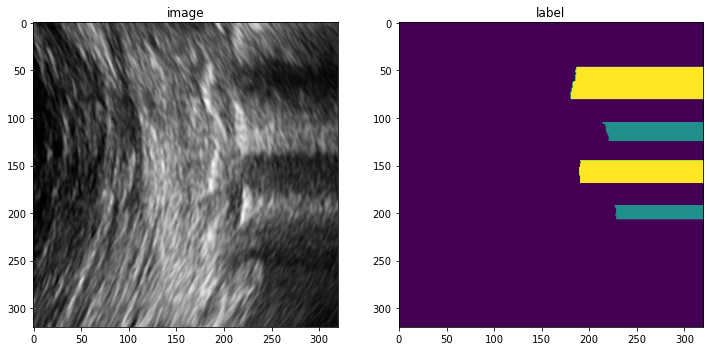

In [4]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 2], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 2])
plt.show()

In [5]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=0)
#train_ds = Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)

sw_batch_size = 4
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)
#val_ds = Dataset(data=val_files, transform=val_transforms)
    
val_loader = DataLoader(val_ds, batch_size=sw_batch_size, num_workers=0)

Loading dataset: 100%|██████████| 19/19 [00:03<00:00,  4.77it/s]


In [6]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
#torch.cuda.empty_cache()

device = torch.device("cuda:0")

model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64),
    strides=(2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [7]:
torch.cuda.empty_cache()

max_epochs = 2000
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=4)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=4)])

root_dir = "."

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (320, 320, 48)
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "BAMC_PTX_3DUNet-4Class-Extruded.best_model.pth"))
                print("saved new best metraic model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/2000
1/4, train_loss: 0.8125
2/4, train_loss: 0.8278
3/4, train_loss: 0.8158
4/4, train_loss: 0.8075
5/4, train_loss: 0.8139
epoch 1 average loss: 0.8155
----------
epoch 2/2000
1/4, train_loss: 0.8082
2/4, train_loss: 0.8052
3/4, train_loss: 0.7965
4/4, train_loss: 0.8080
5/4, train_loss: 0.8089
epoch 2 average loss: 0.8054
saved new best metraic model
current epoch: 2 current mean dice: 0.2057
best mean dice: 0.2057 at epoch: 2
----------
epoch 3/2000
1/4, train_loss: 0.8090
2/4, train_loss: 0.8101
3/4, train_loss: 0.7918
4/4, train_loss: 0.7844
5/4, train_loss: 0.7879
epoch 3 average loss: 0.7966
----------
epoch 4/2000
1/4, train_loss: 0.8111
2/4, train_loss: 0.7852
3/4, train_loss: 0.7724
4/4, train_loss: 0.7923
5/4, train_loss: 0.7840
epoch 4 average loss: 0.7890
current epoch: 4 current mean dice: 0.2029
best mean dice: 0.2057 at epoch: 2
----------
epoch 5/2000
1/4, train_loss: 0.7975
2/4, train_loss: 0.7779
3/4, train_loss: 0.7801
4/4, train_loss: 0.7710
5/4

current epoch: 38 current mean dice: 0.3122
best mean dice: 0.3555 at epoch: 20
----------
epoch 39/2000
1/4, train_loss: 0.6291
2/4, train_loss: 0.6461
3/4, train_loss: 0.6539
4/4, train_loss: 0.6049
5/4, train_loss: 0.6268
epoch 39 average loss: 0.6322
----------
epoch 40/2000
1/4, train_loss: 0.6441
2/4, train_loss: 0.6365
3/4, train_loss: 0.6289
4/4, train_loss: 0.6307
5/4, train_loss: 0.5745
epoch 40 average loss: 0.6229
current epoch: 40 current mean dice: 0.3351
best mean dice: 0.3555 at epoch: 20
----------
epoch 41/2000
1/4, train_loss: 0.6208
2/4, train_loss: 0.6132
3/4, train_loss: 0.6680
4/4, train_loss: 0.6042
5/4, train_loss: 0.6209
epoch 41 average loss: 0.6254
----------
epoch 42/2000
1/4, train_loss: 0.6409
2/4, train_loss: 0.6103
3/4, train_loss: 0.6120
4/4, train_loss: 0.6486
5/4, train_loss: 0.5988
epoch 42 average loss: 0.6221
current epoch: 42 current mean dice: 0.3246
best mean dice: 0.3555 at epoch: 20
----------
epoch 43/2000
1/4, train_loss: 0.6769
2/4, train_

1/4, train_loss: 0.5699
2/4, train_loss: 0.6067
3/4, train_loss: 0.5673
4/4, train_loss: 0.5906
5/4, train_loss: 0.5652
epoch 77 average loss: 0.5799
----------
epoch 78/2000
1/4, train_loss: 0.6047
2/4, train_loss: 0.5064
3/4, train_loss: 0.6621
4/4, train_loss: 0.5864
5/4, train_loss: 0.5402
epoch 78 average loss: 0.5800
current epoch: 78 current mean dice: 0.3470
best mean dice: 0.3555 at epoch: 20
----------
epoch 79/2000
1/4, train_loss: 0.6052
2/4, train_loss: 0.5339
3/4, train_loss: 0.5125
4/4, train_loss: 0.6503
5/4, train_loss: 0.6136
epoch 79 average loss: 0.5831
----------
epoch 80/2000
1/4, train_loss: 0.6338
2/4, train_loss: 0.5503
3/4, train_loss: 0.5896
4/4, train_loss: 0.5614
5/4, train_loss: 0.5616
epoch 80 average loss: 0.5793
current epoch: 80 current mean dice: 0.3200
best mean dice: 0.3555 at epoch: 20
----------
epoch 81/2000
1/4, train_loss: 0.5271
2/4, train_loss: 0.5922
3/4, train_loss: 0.6091
4/4, train_loss: 0.6069
5/4, train_loss: 0.5481
epoch 81 average los

1/4, train_loss: 0.5517
2/4, train_loss: 0.5903
3/4, train_loss: 0.5814
4/4, train_loss: 0.5314
5/4, train_loss: 0.5699
epoch 115 average loss: 0.5650
----------
epoch 116/2000
1/4, train_loss: 0.5800
2/4, train_loss: 0.5422
3/4, train_loss: 0.6094
4/4, train_loss: 0.5206
5/4, train_loss: 0.5494
epoch 116 average loss: 0.5603
saved new best metraic model
current epoch: 116 current mean dice: 0.3734
best mean dice: 0.3734 at epoch: 116
----------
epoch 117/2000
1/4, train_loss: 0.5472
2/4, train_loss: 0.5490
3/4, train_loss: 0.5909
4/4, train_loss: 0.5411
5/4, train_loss: 0.5625
epoch 117 average loss: 0.5581
----------
epoch 118/2000
1/4, train_loss: 0.5265
2/4, train_loss: 0.5902
3/4, train_loss: 0.5677
4/4, train_loss: 0.5392
5/4, train_loss: 0.5885
epoch 118 average loss: 0.5624
saved new best metraic model
current epoch: 118 current mean dice: 0.3772
best mean dice: 0.3772 at epoch: 118
----------
epoch 119/2000
1/4, train_loss: 0.5879
2/4, train_loss: 0.5714
3/4, train_loss: 0.472

2/4, train_loss: 0.5720
3/4, train_loss: 0.4889
4/4, train_loss: 0.5706
5/4, train_loss: 0.5780
epoch 152 average loss: 0.5489
current epoch: 152 current mean dice: 0.3830
best mean dice: 0.4096 at epoch: 140
----------
epoch 153/2000
1/4, train_loss: 0.5911
2/4, train_loss: 0.5096
3/4, train_loss: 0.5452
4/4, train_loss: 0.5426
5/4, train_loss: 0.5621
epoch 153 average loss: 0.5501
----------
epoch 154/2000
1/4, train_loss: 0.5723
2/4, train_loss: 0.5519
3/4, train_loss: 0.5345
4/4, train_loss: 0.5361
5/4, train_loss: 0.5393
epoch 154 average loss: 0.5469
current epoch: 154 current mean dice: 0.3722
best mean dice: 0.4096 at epoch: 140
----------
epoch 155/2000
1/4, train_loss: 0.5706
2/4, train_loss: 0.5263
3/4, train_loss: 0.5365
4/4, train_loss: 0.5776
5/4, train_loss: 0.5419
epoch 155 average loss: 0.5506
----------
epoch 156/2000
1/4, train_loss: 0.5111
2/4, train_loss: 0.5598
3/4, train_loss: 0.6276
4/4, train_loss: 0.5389
5/4, train_loss: 0.5223
epoch 156 average loss: 0.5520
c

4/4, train_loss: 0.5240
5/4, train_loss: 0.5422
epoch 189 average loss: 0.5341
----------
epoch 190/2000
1/4, train_loss: 0.5297
2/4, train_loss: 0.5209
3/4, train_loss: 0.5108
4/4, train_loss: 0.5694
5/4, train_loss: 0.5608
epoch 190 average loss: 0.5383
current epoch: 190 current mean dice: 0.4065
best mean dice: 0.4294 at epoch: 160
----------
epoch 191/2000
1/4, train_loss: 0.5303
2/4, train_loss: 0.5321
3/4, train_loss: 0.5514
4/4, train_loss: 0.5210
5/4, train_loss: 0.5239
epoch 191 average loss: 0.5317
----------
epoch 192/2000
1/4, train_loss: 0.5187
2/4, train_loss: 0.5334
3/4, train_loss: 0.5135
4/4, train_loss: 0.5173
5/4, train_loss: 0.5882
epoch 192 average loss: 0.5342
current epoch: 192 current mean dice: 0.4130
best mean dice: 0.4294 at epoch: 160
----------
epoch 193/2000
1/4, train_loss: 0.5489
2/4, train_loss: 0.5314
3/4, train_loss: 0.5157
4/4, train_loss: 0.5603
5/4, train_loss: 0.5291
epoch 193 average loss: 0.5371
----------
epoch 194/2000
1/4, train_loss: 0.4977

1/4, train_loss: 0.5025
2/4, train_loss: 0.5602
3/4, train_loss: 0.5535
4/4, train_loss: 0.5255
5/4, train_loss: 0.5076
epoch 227 average loss: 0.5299
----------
epoch 228/2000
1/4, train_loss: 0.5509
2/4, train_loss: 0.5394
3/4, train_loss: 0.4925
4/4, train_loss: 0.5188
5/4, train_loss: 0.4914
epoch 228 average loss: 0.5186
current epoch: 228 current mean dice: 0.4256
best mean dice: 0.4624 at epoch: 212
----------
epoch 229/2000
1/4, train_loss: 0.5607
2/4, train_loss: 0.4948
3/4, train_loss: 0.5986
4/4, train_loss: 0.4837
5/4, train_loss: 0.5124
epoch 229 average loss: 0.5300
----------
epoch 230/2000
1/4, train_loss: 0.5843
2/4, train_loss: 0.5296
3/4, train_loss: 0.4996
4/4, train_loss: 0.5202
5/4, train_loss: 0.5010
epoch 230 average loss: 0.5270
current epoch: 230 current mean dice: 0.4197
best mean dice: 0.4624 at epoch: 212
----------
epoch 231/2000
1/4, train_loss: 0.4948
2/4, train_loss: 0.5929
3/4, train_loss: 0.5286
4/4, train_loss: 0.5358
5/4, train_loss: 0.4943
epoch 23

current epoch: 264 current mean dice: 0.4492
best mean dice: 0.4649 at epoch: 254
----------
epoch 265/2000
1/4, train_loss: 0.5293
2/4, train_loss: 0.5051
3/4, train_loss: 0.5072
4/4, train_loss: 0.5588
5/4, train_loss: 0.5423
epoch 265 average loss: 0.5285
----------
epoch 266/2000
1/4, train_loss: 0.5529
2/4, train_loss: 0.5138
3/4, train_loss: 0.5012
4/4, train_loss: 0.5442
5/4, train_loss: 0.5347
epoch 266 average loss: 0.5294
current epoch: 266 current mean dice: 0.4158
best mean dice: 0.4649 at epoch: 254
----------
epoch 267/2000
1/4, train_loss: 0.5053
2/4, train_loss: 0.5260
3/4, train_loss: 0.5786
4/4, train_loss: 0.4902
5/4, train_loss: 0.5064
epoch 267 average loss: 0.5213
----------
epoch 268/2000
1/4, train_loss: 0.5368
2/4, train_loss: 0.5188
3/4, train_loss: 0.5178
4/4, train_loss: 0.5124
5/4, train_loss: 0.4994
epoch 268 average loss: 0.5170
current epoch: 268 current mean dice: 0.4623
best mean dice: 0.4649 at epoch: 254
----------
epoch 269/2000
1/4, train_loss: 0.4

4/4, train_loss: 0.4994
5/4, train_loss: 0.5660
epoch 302 average loss: 0.5260
current epoch: 302 current mean dice: 0.3996
best mean dice: 0.4649 at epoch: 254
----------
epoch 303/2000
1/4, train_loss: 0.4965
2/4, train_loss: 0.5171
3/4, train_loss: 0.4984
4/4, train_loss: 0.5397
5/4, train_loss: 0.5162
epoch 303 average loss: 0.5136
----------
epoch 304/2000
1/4, train_loss: 0.4745
2/4, train_loss: 0.5367
3/4, train_loss: 0.5021
4/4, train_loss: 0.5440
5/4, train_loss: 0.5047
epoch 304 average loss: 0.5124
saved new best metraic model
current epoch: 304 current mean dice: 0.4776
best mean dice: 0.4776 at epoch: 304
----------
epoch 305/2000
1/4, train_loss: 0.5023
2/4, train_loss: 0.4882
3/4, train_loss: 0.4999
4/4, train_loss: 0.5000
5/4, train_loss: 0.5889
epoch 305 average loss: 0.5159
----------
epoch 306/2000
1/4, train_loss: 0.5020
2/4, train_loss: 0.4851
3/4, train_loss: 0.5828
4/4, train_loss: 0.4959
5/4, train_loss: 0.5326
epoch 306 average loss: 0.5197
current epoch: 306 c

1/4, train_loss: 0.4636
2/4, train_loss: 0.4968
3/4, train_loss: 0.5867
4/4, train_loss: 0.5252
5/4, train_loss: 0.5478
epoch 340 average loss: 0.5240
current epoch: 340 current mean dice: 0.4606
best mean dice: 0.4776 at epoch: 304
----------
epoch 341/2000
1/4, train_loss: 0.4800
2/4, train_loss: 0.5508
3/4, train_loss: 0.5016
4/4, train_loss: 0.5296
5/4, train_loss: 0.5392
epoch 341 average loss: 0.5203
----------
epoch 342/2000
1/4, train_loss: 0.4924
2/4, train_loss: 0.5199
3/4, train_loss: 0.4861
4/4, train_loss: 0.5407
5/4, train_loss: 0.5509
epoch 342 average loss: 0.5180
current epoch: 342 current mean dice: 0.4549
best mean dice: 0.4776 at epoch: 304
----------
epoch 343/2000
1/4, train_loss: 0.5345
2/4, train_loss: 0.5092
3/4, train_loss: 0.5082
4/4, train_loss: 0.5137
5/4, train_loss: 0.4850
epoch 343 average loss: 0.5101
----------
epoch 344/2000
1/4, train_loss: 0.4756
2/4, train_loss: 0.5281
3/4, train_loss: 0.5037
4/4, train_loss: 0.5389
5/4, train_loss: 0.5025
epoch 34

5/4, train_loss: 0.4870
epoch 377 average loss: 0.5031
----------
epoch 378/2000
1/4, train_loss: 0.4874
2/4, train_loss: 0.5054
3/4, train_loss: 0.4840
4/4, train_loss: 0.5272
5/4, train_loss: 0.5272
epoch 378 average loss: 0.5062
current epoch: 378 current mean dice: 0.4269
best mean dice: 0.4776 at epoch: 304
----------
epoch 379/2000
1/4, train_loss: 0.5685
2/4, train_loss: 0.4520
3/4, train_loss: 0.5281
4/4, train_loss: 0.5061
5/4, train_loss: 0.4763
epoch 379 average loss: 0.5062
----------
epoch 380/2000
1/4, train_loss: 0.5001
2/4, train_loss: 0.4693
3/4, train_loss: 0.5344
4/4, train_loss: 0.5126
5/4, train_loss: 0.5329
epoch 380 average loss: 0.5099
current epoch: 380 current mean dice: 0.4704
best mean dice: 0.4776 at epoch: 304
----------
epoch 381/2000
1/4, train_loss: 0.4600
2/4, train_loss: 0.5062
3/4, train_loss: 0.5452
4/4, train_loss: 0.5377
5/4, train_loss: 0.5046
epoch 381 average loss: 0.5107
----------
epoch 382/2000
1/4, train_loss: 0.5312
2/4, train_loss: 0.4870

2/4, train_loss: 0.4729
3/4, train_loss: 0.4910
4/4, train_loss: 0.5559
5/4, train_loss: 0.5182
epoch 415 average loss: 0.5026
----------
epoch 416/2000
1/4, train_loss: 0.4490
2/4, train_loss: 0.4933
3/4, train_loss: 0.4883
4/4, train_loss: 0.5803
5/4, train_loss: 0.5016
epoch 416 average loss: 0.5025
current epoch: 416 current mean dice: 0.3618
best mean dice: 0.4776 at epoch: 304
----------
epoch 417/2000
1/4, train_loss: 0.4972
2/4, train_loss: 0.4717
3/4, train_loss: 0.4999
4/4, train_loss: 0.5186
5/4, train_loss: 0.5279
epoch 417 average loss: 0.5031
----------
epoch 418/2000
1/4, train_loss: 0.5019
2/4, train_loss: 0.5016
3/4, train_loss: 0.5286
4/4, train_loss: 0.5004
5/4, train_loss: 0.4953
epoch 418 average loss: 0.5056
current epoch: 418 current mean dice: 0.4463
best mean dice: 0.4776 at epoch: 304
----------
epoch 419/2000
1/4, train_loss: 0.5179
2/4, train_loss: 0.4982
3/4, train_loss: 0.5461
4/4, train_loss: 0.4913
5/4, train_loss: 0.4613
epoch 419 average loss: 0.5030
-

1/4, train_loss: 0.5046
2/4, train_loss: 0.4738
3/4, train_loss: 0.4896
4/4, train_loss: 0.4900
5/4, train_loss: 0.5437
epoch 453 average loss: 0.5003
----------
epoch 454/2000
1/4, train_loss: 0.5527
2/4, train_loss: 0.4840
3/4, train_loss: 0.4670
4/4, train_loss: 0.4942
5/4, train_loss: 0.5110
epoch 454 average loss: 0.5018
current epoch: 454 current mean dice: 0.4543
best mean dice: 0.4815 at epoch: 434
----------
epoch 455/2000
1/4, train_loss: 0.4768
2/4, train_loss: 0.4527
3/4, train_loss: 0.5840
4/4, train_loss: 0.4916
5/4, train_loss: 0.4945
epoch 455 average loss: 0.4999
----------
epoch 456/2000
1/4, train_loss: 0.4866
2/4, train_loss: 0.5023
3/4, train_loss: 0.5435
4/4, train_loss: 0.4740
5/4, train_loss: 0.5110
epoch 456 average loss: 0.5035
current epoch: 456 current mean dice: 0.4628
best mean dice: 0.4815 at epoch: 434
----------
epoch 457/2000
1/4, train_loss: 0.5064
2/4, train_loss: 0.5203
3/4, train_loss: 0.5189
4/4, train_loss: 0.4590
5/4, train_loss: 0.4708
epoch 45

current epoch: 490 current mean dice: 0.4213
best mean dice: 0.4845 at epoch: 466
----------
epoch 491/2000
1/4, train_loss: 0.4598
2/4, train_loss: 0.5261
3/4, train_loss: 0.5220
4/4, train_loss: 0.4978
5/4, train_loss: 0.4607
epoch 491 average loss: 0.4933
----------
epoch 492/2000
1/4, train_loss: 0.4915
2/4, train_loss: 0.5240
3/4, train_loss: 0.4883
4/4, train_loss: 0.4888
5/4, train_loss: 0.4869
epoch 492 average loss: 0.4959
current epoch: 492 current mean dice: 0.4224
best mean dice: 0.4845 at epoch: 466
----------
epoch 493/2000
1/4, train_loss: 0.4687
2/4, train_loss: 0.5582
3/4, train_loss: 0.5170
4/4, train_loss: 0.4864
5/4, train_loss: 0.4662
epoch 493 average loss: 0.4993
----------
epoch 494/2000
1/4, train_loss: 0.4703
2/4, train_loss: 0.4938
3/4, train_loss: 0.4701
4/4, train_loss: 0.4982
5/4, train_loss: 0.5270
epoch 494 average loss: 0.4919
current epoch: 494 current mean dice: 0.3665
best mean dice: 0.4845 at epoch: 466
----------
epoch 495/2000
1/4, train_loss: 0.4

4/4, train_loss: 0.5540
5/4, train_loss: 0.4725
epoch 528 average loss: 0.4896
current epoch: 528 current mean dice: 0.4427
best mean dice: 0.4845 at epoch: 466
----------
epoch 529/2000
1/4, train_loss: 0.4963
2/4, train_loss: 0.4992
3/4, train_loss: 0.5096
4/4, train_loss: 0.4875
5/4, train_loss: 0.4611
epoch 529 average loss: 0.4907
----------
epoch 530/2000
1/4, train_loss: 0.4855
2/4, train_loss: 0.5023
3/4, train_loss: 0.4819
4/4, train_loss: 0.4937
5/4, train_loss: 0.5035
epoch 530 average loss: 0.4934
current epoch: 530 current mean dice: 0.4773
best mean dice: 0.4845 at epoch: 466
----------
epoch 531/2000
1/4, train_loss: 0.4994
2/4, train_loss: 0.4613
3/4, train_loss: 0.5060
4/4, train_loss: 0.5199
5/4, train_loss: 0.4918
epoch 531 average loss: 0.4957
----------
epoch 532/2000
1/4, train_loss: 0.4782
2/4, train_loss: 0.5061
3/4, train_loss: 0.4416
4/4, train_loss: 0.5542
5/4, train_loss: 0.4852
epoch 532 average loss: 0.4931
current epoch: 532 current mean dice: 0.4512
best

1/4, train_loss: 0.5045
2/4, train_loss: 0.4626
3/4, train_loss: 0.5268
4/4, train_loss: 0.4748
5/4, train_loss: 0.4693
epoch 566 average loss: 0.4876
current epoch: 566 current mean dice: 0.4577
best mean dice: 0.4845 at epoch: 466
----------
epoch 567/2000
1/4, train_loss: 0.5359
2/4, train_loss: 0.4875
3/4, train_loss: 0.4826
4/4, train_loss: 0.4859
5/4, train_loss: 0.4487
epoch 567 average loss: 0.4881
----------
epoch 568/2000
1/4, train_loss: 0.5069
2/4, train_loss: 0.4832
3/4, train_loss: 0.4888
4/4, train_loss: 0.4691
5/4, train_loss: 0.5063
epoch 568 average loss: 0.4909
current epoch: 568 current mean dice: 0.4402
best mean dice: 0.4845 at epoch: 466
----------
epoch 569/2000
1/4, train_loss: 0.4343
2/4, train_loss: 0.4856
3/4, train_loss: 0.4956
4/4, train_loss: 0.5248
5/4, train_loss: 0.5257
epoch 569 average loss: 0.4932
----------
epoch 570/2000
1/4, train_loss: 0.5372
2/4, train_loss: 0.4780
3/4, train_loss: 0.4594
4/4, train_loss: 0.4758
5/4, train_loss: 0.4954
epoch 57

5/4, train_loss: 0.5479
epoch 603 average loss: 0.4874
----------
epoch 604/2000
1/4, train_loss: 0.4381
2/4, train_loss: 0.5236
3/4, train_loss: 0.5176
4/4, train_loss: 0.5052
5/4, train_loss: 0.4482
epoch 604 average loss: 0.4865
current epoch: 604 current mean dice: 0.4524
best mean dice: 0.4845 at epoch: 466
----------
epoch 605/2000
1/4, train_loss: 0.5218
2/4, train_loss: 0.4518
3/4, train_loss: 0.5034
4/4, train_loss: 0.4661
5/4, train_loss: 0.4822
epoch 605 average loss: 0.4850
----------
epoch 606/2000
1/4, train_loss: 0.5174
2/4, train_loss: 0.4838
3/4, train_loss: 0.5218
4/4, train_loss: 0.4423
5/4, train_loss: 0.4745
epoch 606 average loss: 0.4880
current epoch: 606 current mean dice: 0.3808
best mean dice: 0.4845 at epoch: 466
----------
epoch 607/2000
1/4, train_loss: 0.4825
2/4, train_loss: 0.4347
3/4, train_loss: 0.5264
4/4, train_loss: 0.5205
5/4, train_loss: 0.4933
epoch 607 average loss: 0.4915
----------
epoch 608/2000
1/4, train_loss: 0.4931
2/4, train_loss: 0.5204

1/4, train_loss: 0.5504
2/4, train_loss: 0.4761
3/4, train_loss: 0.4530
4/4, train_loss: 0.4796
5/4, train_loss: 0.4627
epoch 641 average loss: 0.4843
----------
epoch 642/2000
1/4, train_loss: 0.4576
2/4, train_loss: 0.4960
3/4, train_loss: 0.4986
4/4, train_loss: 0.4659
5/4, train_loss: 0.5036
epoch 642 average loss: 0.4843
current epoch: 642 current mean dice: 0.3726
best mean dice: 0.4924 at epoch: 616
----------
epoch 643/2000
1/4, train_loss: 0.4536
2/4, train_loss: 0.4865
3/4, train_loss: 0.4823
4/4, train_loss: 0.5311
5/4, train_loss: 0.4660
epoch 643 average loss: 0.4839
----------
epoch 644/2000
1/4, train_loss: 0.4744
2/4, train_loss: 0.4685
3/4, train_loss: 0.4877
4/4, train_loss: 0.4865
5/4, train_loss: 0.5346
epoch 644 average loss: 0.4903
current epoch: 644 current mean dice: 0.4451
best mean dice: 0.4924 at epoch: 616
----------
epoch 645/2000
1/4, train_loss: 0.4600
2/4, train_loss: 0.5056
3/4, train_loss: 0.5323
4/4, train_loss: 0.4689
5/4, train_loss: 0.4453
epoch 64

1/4, train_loss: 0.4693
2/4, train_loss: 0.4354
3/4, train_loss: 0.4751
4/4, train_loss: 0.5496
5/4, train_loss: 0.4817
epoch 679 average loss: 0.4822
----------
epoch 680/2000
1/4, train_loss: 0.4285
2/4, train_loss: 0.5238
3/4, train_loss: 0.5363
4/4, train_loss: 0.4931
5/4, train_loss: 0.4474
epoch 680 average loss: 0.4858
current epoch: 680 current mean dice: 0.4268
best mean dice: 0.4924 at epoch: 616
----------
epoch 681/2000
1/4, train_loss: 0.4851
2/4, train_loss: 0.5146
3/4, train_loss: 0.4714
4/4, train_loss: 0.4995
5/4, train_loss: 0.4266
epoch 681 average loss: 0.4794
----------
epoch 682/2000
1/4, train_loss: 0.4678
2/4, train_loss: 0.4886
3/4, train_loss: 0.4800
4/4, train_loss: 0.4800
5/4, train_loss: 0.4921
epoch 682 average loss: 0.4817
current epoch: 682 current mean dice: 0.4865
best mean dice: 0.4924 at epoch: 616
----------
epoch 683/2000
1/4, train_loss: 0.4800
2/4, train_loss: 0.5000
3/4, train_loss: 0.4599
4/4, train_loss: 0.5302
5/4, train_loss: 0.4551
epoch 68

1/4, train_loss: 0.4671
2/4, train_loss: 0.4368
3/4, train_loss: 0.5032
4/4, train_loss: 0.4561
5/4, train_loss: 0.5500
epoch 717 average loss: 0.4826
----------
epoch 718/2000
1/4, train_loss: 0.5164
2/4, train_loss: 0.4790
3/4, train_loss: 0.4513
4/4, train_loss: 0.4266
5/4, train_loss: 0.4999
epoch 718 average loss: 0.4746
current epoch: 718 current mean dice: 0.4181
best mean dice: 0.4924 at epoch: 616
----------
epoch 719/2000
1/4, train_loss: 0.5051
2/4, train_loss: 0.4707
3/4, train_loss: 0.4214
4/4, train_loss: 0.4923
5/4, train_loss: 0.5268
epoch 719 average loss: 0.4833
----------
epoch 720/2000
1/4, train_loss: 0.4791
2/4, train_loss: 0.4903
3/4, train_loss: 0.4805
4/4, train_loss: 0.4628
5/4, train_loss: 0.4938
epoch 720 average loss: 0.4813
saved new best metraic model
current epoch: 720 current mean dice: 0.5018
best mean dice: 0.5018 at epoch: 720
----------
epoch 721/2000
1/4, train_loss: 0.4482
2/4, train_loss: 0.4946
3/4, train_loss: 0.4794
4/4, train_loss: 0.4407
5/4

current epoch: 754 current mean dice: 0.4566
best mean dice: 0.5018 at epoch: 720
----------
epoch 755/2000
1/4, train_loss: 0.5124
2/4, train_loss: 0.4887
3/4, train_loss: 0.4216
4/4, train_loss: 0.4798
5/4, train_loss: 0.5009
epoch 755 average loss: 0.4807
----------
epoch 756/2000
1/4, train_loss: 0.4822
2/4, train_loss: 0.5201
3/4, train_loss: 0.4354
4/4, train_loss: 0.4638
5/4, train_loss: 0.4758
epoch 756 average loss: 0.4755
current epoch: 756 current mean dice: 0.4732
best mean dice: 0.5018 at epoch: 720
----------
epoch 757/2000
1/4, train_loss: 0.4540
2/4, train_loss: 0.4681
3/4, train_loss: 0.4889
4/4, train_loss: 0.5164
5/4, train_loss: 0.4629
epoch 757 average loss: 0.4781
----------
epoch 758/2000
1/4, train_loss: 0.4615
2/4, train_loss: 0.4670
3/4, train_loss: 0.4898
4/4, train_loss: 0.4981
5/4, train_loss: 0.4989
epoch 758 average loss: 0.4831
current epoch: 758 current mean dice: 0.4529
best mean dice: 0.5018 at epoch: 720
----------
epoch 759/2000
1/4, train_loss: 0.5

4/4, train_loss: 0.4364
5/4, train_loss: 0.5139
epoch 792 average loss: 0.4733
current epoch: 792 current mean dice: 0.4569
best mean dice: 0.5018 at epoch: 720
----------
epoch 793/2000
1/4, train_loss: 0.4996
2/4, train_loss: 0.4547
3/4, train_loss: 0.4594
4/4, train_loss: 0.4523
5/4, train_loss: 0.4607
epoch 793 average loss: 0.4653
----------
epoch 794/2000
1/4, train_loss: 0.4191
2/4, train_loss: 0.5054
3/4, train_loss: 0.4558
4/4, train_loss: 0.5021
5/4, train_loss: 0.5066
epoch 794 average loss: 0.4778
current epoch: 794 current mean dice: 0.4602
best mean dice: 0.5018 at epoch: 720
----------
epoch 795/2000
1/4, train_loss: 0.4215
2/4, train_loss: 0.5025
3/4, train_loss: 0.4513
4/4, train_loss: 0.4798
5/4, train_loss: 0.4903
epoch 795 average loss: 0.4691
----------
epoch 796/2000
1/4, train_loss: 0.5334
2/4, train_loss: 0.4720
3/4, train_loss: 0.4429
4/4, train_loss: 0.4516
5/4, train_loss: 0.4640
epoch 796 average loss: 0.4728
current epoch: 796 current mean dice: 0.4590
best

1/4, train_loss: 0.5220
2/4, train_loss: 0.4499
3/4, train_loss: 0.4321
4/4, train_loss: 0.5404
5/4, train_loss: 0.4096
epoch 830 average loss: 0.4708
current epoch: 830 current mean dice: 0.4691
best mean dice: 0.5018 at epoch: 720
----------
epoch 831/2000
1/4, train_loss: 0.4463
2/4, train_loss: 0.4389
3/4, train_loss: 0.4660
4/4, train_loss: 0.5201
5/4, train_loss: 0.4893
epoch 831 average loss: 0.4721
----------
epoch 832/2000
1/4, train_loss: 0.4924
2/4, train_loss: 0.4876
3/4, train_loss: 0.4646
4/4, train_loss: 0.4604
5/4, train_loss: 0.4676
epoch 832 average loss: 0.4745
current epoch: 832 current mean dice: 0.4784
best mean dice: 0.5018 at epoch: 720
----------
epoch 833/2000
1/4, train_loss: 0.4906
2/4, train_loss: 0.5055
3/4, train_loss: 0.4697
4/4, train_loss: 0.4985
5/4, train_loss: 0.4315
epoch 833 average loss: 0.4792
----------
epoch 834/2000
1/4, train_loss: 0.4827
2/4, train_loss: 0.4359
3/4, train_loss: 0.4632
4/4, train_loss: 0.4883
5/4, train_loss: 0.5046
epoch 83

5/4, train_loss: 0.4791
epoch 867 average loss: 0.4745
----------
epoch 868/2000
1/4, train_loss: 0.4468
2/4, train_loss: 0.4627
3/4, train_loss: 0.4647
4/4, train_loss: 0.5188
5/4, train_loss: 0.4378
epoch 868 average loss: 0.4662
current epoch: 868 current mean dice: 0.4498
best mean dice: 0.5018 at epoch: 720
----------
epoch 869/2000
1/4, train_loss: 0.4566
2/4, train_loss: 0.4315
3/4, train_loss: 0.4992
4/4, train_loss: 0.4598
5/4, train_loss: 0.5005
epoch 869 average loss: 0.4695
----------
epoch 870/2000
1/4, train_loss: 0.4286
2/4, train_loss: 0.4703
3/4, train_loss: 0.4911
4/4, train_loss: 0.4835
5/4, train_loss: 0.5042
epoch 870 average loss: 0.4755
current epoch: 870 current mean dice: 0.4429
best mean dice: 0.5018 at epoch: 720
----------
epoch 871/2000
1/4, train_loss: 0.4772
2/4, train_loss: 0.4418
3/4, train_loss: 0.4659
4/4, train_loss: 0.4557
5/4, train_loss: 0.5569
epoch 871 average loss: 0.4795
----------
epoch 872/2000
1/4, train_loss: 0.4776
2/4, train_loss: 0.4742

2/4, train_loss: 0.5156
3/4, train_loss: 0.4476
4/4, train_loss: 0.5062
5/4, train_loss: 0.4574
epoch 905 average loss: 0.4695
----------
epoch 906/2000
1/4, train_loss: 0.4622
2/4, train_loss: 0.4734
3/4, train_loss: 0.5016
4/4, train_loss: 0.5230
5/4, train_loss: 0.4007
epoch 906 average loss: 0.4722
current epoch: 906 current mean dice: 0.4642
best mean dice: 0.5018 at epoch: 720
----------
epoch 907/2000
1/4, train_loss: 0.4585
2/4, train_loss: 0.5099
3/4, train_loss: 0.4194
4/4, train_loss: 0.5085
5/4, train_loss: 0.4573
epoch 907 average loss: 0.4707
----------
epoch 908/2000
1/4, train_loss: 0.4925
2/4, train_loss: 0.4816
3/4, train_loss: 0.4411
4/4, train_loss: 0.4682
5/4, train_loss: 0.4426
epoch 908 average loss: 0.4652
current epoch: 908 current mean dice: 0.4647
best mean dice: 0.5018 at epoch: 720
----------
epoch 909/2000
1/4, train_loss: 0.4874
2/4, train_loss: 0.4835
3/4, train_loss: 0.4160
4/4, train_loss: 0.4532
5/4, train_loss: 0.4890
epoch 909 average loss: 0.4658
-

1/4, train_loss: 0.4443
2/4, train_loss: 0.4560
3/4, train_loss: 0.4961
4/4, train_loss: 0.4831
5/4, train_loss: 0.4779
epoch 943 average loss: 0.4715
----------
epoch 944/2000
1/4, train_loss: 0.4278
2/4, train_loss: 0.4419
3/4, train_loss: 0.4830
4/4, train_loss: 0.4422
5/4, train_loss: 0.5119
epoch 944 average loss: 0.4614
current epoch: 944 current mean dice: 0.4744
best mean dice: 0.5071 at epoch: 912
----------
epoch 945/2000
1/4, train_loss: 0.4963
2/4, train_loss: 0.4550
3/4, train_loss: 0.4931
4/4, train_loss: 0.4530
5/4, train_loss: 0.4613
epoch 945 average loss: 0.4717
----------
epoch 946/2000
1/4, train_loss: 0.4787
2/4, train_loss: 0.4775
3/4, train_loss: 0.4343
4/4, train_loss: 0.4328
5/4, train_loss: 0.4976
epoch 946 average loss: 0.4642
current epoch: 946 current mean dice: 0.4315
best mean dice: 0.5071 at epoch: 912
----------
epoch 947/2000
1/4, train_loss: 0.4983
2/4, train_loss: 0.4377
3/4, train_loss: 0.4748
4/4, train_loss: 0.4428
5/4, train_loss: 0.4784
epoch 94

1/4, train_loss: 0.4438
2/4, train_loss: 0.4632
3/4, train_loss: 0.4572
4/4, train_loss: 0.4939
5/4, train_loss: 0.4519
epoch 981 average loss: 0.4620
----------
epoch 982/2000
1/4, train_loss: 0.4916
2/4, train_loss: 0.4482
3/4, train_loss: 0.4441
4/4, train_loss: 0.4747
5/4, train_loss: 0.4279
epoch 982 average loss: 0.4573
saved new best metraic model
current epoch: 982 current mean dice: 0.5080
best mean dice: 0.5080 at epoch: 982
----------
epoch 983/2000
1/4, train_loss: 0.4506
2/4, train_loss: 0.4516
3/4, train_loss: 0.4638
4/4, train_loss: 0.4666
5/4, train_loss: 0.4846
epoch 983 average loss: 0.4634
----------
epoch 984/2000
1/4, train_loss: 0.4610
2/4, train_loss: 0.5067
3/4, train_loss: 0.4611
4/4, train_loss: 0.4561
5/4, train_loss: 0.4590
epoch 984 average loss: 0.4688
current epoch: 984 current mean dice: 0.4783
best mean dice: 0.5080 at epoch: 982
----------
epoch 985/2000
1/4, train_loss: 0.4721
2/4, train_loss: 0.4254
3/4, train_loss: 0.4593
4/4, train_loss: 0.4523
5/4

5/4, train_loss: 0.4541
epoch 1018 average loss: 0.4597
current epoch: 1018 current mean dice: 0.4675
best mean dice: 0.5080 at epoch: 982
----------
epoch 1019/2000
1/4, train_loss: 0.4104
2/4, train_loss: 0.5277
3/4, train_loss: 0.4113
4/4, train_loss: 0.4607
5/4, train_loss: 0.5036
epoch 1019 average loss: 0.4627
----------
epoch 1020/2000
1/4, train_loss: 0.4951
2/4, train_loss: 0.4248
3/4, train_loss: 0.4873
4/4, train_loss: 0.4122
5/4, train_loss: 0.4742
epoch 1020 average loss: 0.4587
current epoch: 1020 current mean dice: 0.4651
best mean dice: 0.5080 at epoch: 982
----------
epoch 1021/2000
1/4, train_loss: 0.4419
2/4, train_loss: 0.4812
3/4, train_loss: 0.4814
4/4, train_loss: 0.4960
5/4, train_loss: 0.4104
epoch 1021 average loss: 0.4622
----------
epoch 1022/2000
1/4, train_loss: 0.4353
2/4, train_loss: 0.4715
3/4, train_loss: 0.5125
4/4, train_loss: 0.4281
5/4, train_loss: 0.4145
epoch 1022 average loss: 0.4524
current epoch: 1022 current mean dice: 0.4772
best mean dice: 

5/4, train_loss: 0.4919
epoch 1055 average loss: 0.4598
----------
epoch 1056/2000
1/4, train_loss: 0.4730
2/4, train_loss: 0.4330
3/4, train_loss: 0.5102
4/4, train_loss: 0.4277
5/4, train_loss: 0.4613
epoch 1056 average loss: 0.4610
current epoch: 1056 current mean dice: 0.4875
best mean dice: 0.5080 at epoch: 982
----------
epoch 1057/2000
1/4, train_loss: 0.4791
2/4, train_loss: 0.4327
3/4, train_loss: 0.4887
4/4, train_loss: 0.4754
5/4, train_loss: 0.4381
epoch 1057 average loss: 0.4628
----------
epoch 1058/2000
1/4, train_loss: 0.4951
2/4, train_loss: 0.4433
3/4, train_loss: 0.4533
4/4, train_loss: 0.4474
5/4, train_loss: 0.4568
epoch 1058 average loss: 0.4592
current epoch: 1058 current mean dice: 0.4873
best mean dice: 0.5080 at epoch: 982
----------
epoch 1059/2000
1/4, train_loss: 0.4692
2/4, train_loss: 0.4361
3/4, train_loss: 0.4547
4/4, train_loss: 0.4247
5/4, train_loss: 0.4883
epoch 1059 average loss: 0.4546
----------
epoch 1060/2000
1/4, train_loss: 0.4341
2/4, train_

current epoch: 1092 current mean dice: 0.4211
best mean dice: 0.5088 at epoch: 1080
----------
epoch 1093/2000
1/4, train_loss: 0.4523
2/4, train_loss: 0.4650
3/4, train_loss: 0.4577
4/4, train_loss: 0.4651
5/4, train_loss: 0.4466
epoch 1093 average loss: 0.4574
----------
epoch 1094/2000
1/4, train_loss: 0.4453
2/4, train_loss: 0.4575
3/4, train_loss: 0.5191
4/4, train_loss: 0.4470
5/4, train_loss: 0.4249
epoch 1094 average loss: 0.4588
current epoch: 1094 current mean dice: 0.4765
best mean dice: 0.5088 at epoch: 1080
----------
epoch 1095/2000
1/4, train_loss: 0.4368
2/4, train_loss: 0.4986
3/4, train_loss: 0.4678
4/4, train_loss: 0.4335
5/4, train_loss: 0.4679
epoch 1095 average loss: 0.4609
----------
epoch 1096/2000
1/4, train_loss: 0.4357
2/4, train_loss: 0.4346
3/4, train_loss: 0.4668
4/4, train_loss: 0.4595
5/4, train_loss: 0.4865
epoch 1096 average loss: 0.4566
current epoch: 1096 current mean dice: 0.4787
best mean dice: 0.5088 at epoch: 1080
----------
epoch 1097/2000
1/4, 

1/4, train_loss: 0.4305
2/4, train_loss: 0.4457
3/4, train_loss: 0.4523
4/4, train_loss: 0.4644
5/4, train_loss: 0.5090
epoch 1130 average loss: 0.4604
current epoch: 1130 current mean dice: 0.4838
best mean dice: 0.5088 at epoch: 1080
----------
epoch 1131/2000
1/4, train_loss: 0.4584
2/4, train_loss: 0.4851
3/4, train_loss: 0.4613
4/4, train_loss: 0.4691
5/4, train_loss: 0.4658
epoch 1131 average loss: 0.4679
----------
epoch 1132/2000
1/4, train_loss: 0.4270
2/4, train_loss: 0.4410
3/4, train_loss: 0.5077
4/4, train_loss: 0.4439
5/4, train_loss: 0.4598
epoch 1132 average loss: 0.4559
saved new best metraic model
current epoch: 1132 current mean dice: 0.5162
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1133/2000
1/4, train_loss: 0.4643
2/4, train_loss: 0.5170
3/4, train_loss: 0.4648
4/4, train_loss: 0.4360
5/4, train_loss: 0.4215
epoch 1133 average loss: 0.4607
----------
epoch 1134/2000
1/4, train_loss: 0.4566
2/4, train_loss: 0.4225
3/4, train_loss: 0.4730
4/4, train_loss

1/4, train_loss: 0.4316
2/4, train_loss: 0.4075
3/4, train_loss: 0.4461
4/4, train_loss: 0.5351
5/4, train_loss: 0.4982
epoch 1167 average loss: 0.4637
----------
epoch 1168/2000
1/4, train_loss: 0.4295
2/4, train_loss: 0.4543
3/4, train_loss: 0.4484
4/4, train_loss: 0.4565
5/4, train_loss: 0.4833
epoch 1168 average loss: 0.4544
current epoch: 1168 current mean dice: 0.4983
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1169/2000
1/4, train_loss: 0.4123
2/4, train_loss: 0.4590
3/4, train_loss: 0.4726
4/4, train_loss: 0.4556
5/4, train_loss: 0.4675
epoch 1169 average loss: 0.4534
----------
epoch 1170/2000
1/4, train_loss: 0.4286
2/4, train_loss: 0.4565
3/4, train_loss: 0.4616
4/4, train_loss: 0.4537
5/4, train_loss: 0.5118
epoch 1170 average loss: 0.4624
current epoch: 1170 current mean dice: 0.4782
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1171/2000
1/4, train_loss: 0.4679
2/4, train_loss: 0.4421
3/4, train_loss: 0.4283
4/4, train_loss: 0.5146
5/4, train_loss: 0.4

4/4, train_loss: 0.4677
5/4, train_loss: 0.4341
epoch 1204 average loss: 0.4513
current epoch: 1204 current mean dice: 0.4856
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1205/2000
1/4, train_loss: 0.3961
2/4, train_loss: 0.4983
3/4, train_loss: 0.4659
4/4, train_loss: 0.4783
5/4, train_loss: 0.4046
epoch 1205 average loss: 0.4486
----------
epoch 1206/2000
1/4, train_loss: 0.5146
2/4, train_loss: 0.4377
3/4, train_loss: 0.4459
4/4, train_loss: 0.4281
5/4, train_loss: 0.4224
epoch 1206 average loss: 0.4497
current epoch: 1206 current mean dice: 0.4782
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1207/2000
1/4, train_loss: 0.4326
2/4, train_loss: 0.4198
3/4, train_loss: 0.4412
4/4, train_loss: 0.5133
5/4, train_loss: 0.4735
epoch 1207 average loss: 0.4561
----------
epoch 1208/2000
1/4, train_loss: 0.4580
2/4, train_loss: 0.4418
3/4, train_loss: 0.4666
4/4, train_loss: 0.4552
5/4, train_loss: 0.4626
epoch 1208 average loss: 0.4569
current epoch: 1208 current mean dic

3/4, train_loss: 0.4509
4/4, train_loss: 0.4770
5/4, train_loss: 0.4520
epoch 1241 average loss: 0.4530
----------
epoch 1242/2000
1/4, train_loss: 0.4053
2/4, train_loss: 0.4421
3/4, train_loss: 0.4332
4/4, train_loss: 0.5109
5/4, train_loss: 0.4603
epoch 1242 average loss: 0.4504
current epoch: 1242 current mean dice: 0.5134
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1243/2000
1/4, train_loss: 0.4598
2/4, train_loss: 0.4271
3/4, train_loss: 0.4451
4/4, train_loss: 0.4548
5/4, train_loss: 0.4592
epoch 1243 average loss: 0.4492
----------
epoch 1244/2000
1/4, train_loss: 0.4053
2/4, train_loss: 0.4819
3/4, train_loss: 0.4198
4/4, train_loss: 0.4690
5/4, train_loss: 0.4744
epoch 1244 average loss: 0.4501
current epoch: 1244 current mean dice: 0.4706
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1245/2000
1/4, train_loss: 0.4774
2/4, train_loss: 0.4042
3/4, train_loss: 0.4147
4/4, train_loss: 0.4987
5/4, train_loss: 0.5049
epoch 1245 average loss: 0.4600
----------
e

current epoch: 1278 current mean dice: 0.4646
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1279/2000
1/4, train_loss: 0.4959
2/4, train_loss: 0.4417
3/4, train_loss: 0.4332
4/4, train_loss: 0.4636
5/4, train_loss: 0.4483
epoch 1279 average loss: 0.4566
----------
epoch 1280/2000
1/4, train_loss: 0.4411
2/4, train_loss: 0.5243
3/4, train_loss: 0.4362
4/4, train_loss: 0.4064
5/4, train_loss: 0.4521
epoch 1280 average loss: 0.4520
current epoch: 1280 current mean dice: 0.4778
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1281/2000
1/4, train_loss: 0.4053
2/4, train_loss: 0.4970
3/4, train_loss: 0.4722
4/4, train_loss: 0.4668
5/4, train_loss: 0.4075
epoch 1281 average loss: 0.4498
----------
epoch 1282/2000
1/4, train_loss: 0.4602
2/4, train_loss: 0.4253
3/4, train_loss: 0.5141
4/4, train_loss: 0.4254
5/4, train_loss: 0.4563
epoch 1282 average loss: 0.4563
current epoch: 1282 current mean dice: 0.4448
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1283/2000
1/4, 

1/4, train_loss: 0.4689
2/4, train_loss: 0.4589
3/4, train_loss: 0.4290
4/4, train_loss: 0.4692
5/4, train_loss: 0.4595
epoch 1316 average loss: 0.4571
current epoch: 1316 current mean dice: 0.4827
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1317/2000
1/4, train_loss: 0.4409
2/4, train_loss: 0.4652
3/4, train_loss: 0.4338
4/4, train_loss: 0.4685
5/4, train_loss: 0.4360
epoch 1317 average loss: 0.4489
----------
epoch 1318/2000
1/4, train_loss: 0.4856
2/4, train_loss: 0.4848
3/4, train_loss: 0.4053
4/4, train_loss: 0.4261
5/4, train_loss: 0.4575
epoch 1318 average loss: 0.4519
current epoch: 1318 current mean dice: 0.4803
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1319/2000
1/4, train_loss: 0.4804
2/4, train_loss: 0.4349
3/4, train_loss: 0.4963
4/4, train_loss: 0.4179
5/4, train_loss: 0.4275
epoch 1319 average loss: 0.4514
----------
epoch 1320/2000
1/4, train_loss: 0.4566
2/4, train_loss: 0.4625
3/4, train_loss: 0.4634
4/4, train_loss: 0.4777
5/4, train_loss: 0.4

1/4, train_loss: 0.3993
2/4, train_loss: 0.5021
3/4, train_loss: 0.4824
4/4, train_loss: 0.4163
5/4, train_loss: 0.4415
epoch 1353 average loss: 0.4483
----------
epoch 1354/2000
1/4, train_loss: 0.4268
2/4, train_loss: 0.4262
3/4, train_loss: 0.4112
4/4, train_loss: 0.4591
5/4, train_loss: 0.5039
epoch 1354 average loss: 0.4454
current epoch: 1354 current mean dice: 0.4354
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1355/2000
1/4, train_loss: 0.4258
2/4, train_loss: 0.4551
3/4, train_loss: 0.4770
4/4, train_loss: 0.4727
5/4, train_loss: 0.4191
epoch 1355 average loss: 0.4499
----------
epoch 1356/2000
1/4, train_loss: 0.4311
2/4, train_loss: 0.4197
3/4, train_loss: 0.4723
4/4, train_loss: 0.4377
5/4, train_loss: 0.4894
epoch 1356 average loss: 0.4500
current epoch: 1356 current mean dice: 0.4735
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1357/2000
1/4, train_loss: 0.4013
2/4, train_loss: 0.4680
3/4, train_loss: 0.4480
4/4, train_loss: 0.4714
5/4, train_loss: 0.4

4/4, train_loss: 0.4644
5/4, train_loss: 0.4765
epoch 1390 average loss: 0.4483
current epoch: 1390 current mean dice: 0.4500
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1391/2000
1/4, train_loss: 0.4050
2/4, train_loss: 0.4522
3/4, train_loss: 0.4238
4/4, train_loss: 0.4694
5/4, train_loss: 0.4806
epoch 1391 average loss: 0.4462
----------
epoch 1392/2000
1/4, train_loss: 0.4782
2/4, train_loss: 0.4714
3/4, train_loss: 0.4343
4/4, train_loss: 0.3957
5/4, train_loss: 0.4548
epoch 1392 average loss: 0.4469
current epoch: 1392 current mean dice: 0.4899
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1393/2000
1/4, train_loss: 0.4301
2/4, train_loss: 0.4074
3/4, train_loss: 0.4455
4/4, train_loss: 0.4523
5/4, train_loss: 0.4888
epoch 1393 average loss: 0.4449
----------
epoch 1394/2000
1/4, train_loss: 0.4229
2/4, train_loss: 0.4481
3/4, train_loss: 0.4391
4/4, train_loss: 0.4444
5/4, train_loss: 0.4527
epoch 1394 average loss: 0.4414
current epoch: 1394 current mean dic

3/4, train_loss: 0.4708
4/4, train_loss: 0.4621
5/4, train_loss: 0.4280
epoch 1427 average loss: 0.4427
----------
epoch 1428/2000
1/4, train_loss: 0.4110
2/4, train_loss: 0.4278
3/4, train_loss: 0.4897
4/4, train_loss: 0.4378
5/4, train_loss: 0.4605
epoch 1428 average loss: 0.4454
current epoch: 1428 current mean dice: 0.4769
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1429/2000
1/4, train_loss: 0.4115
2/4, train_loss: 0.5060
3/4, train_loss: 0.4645
4/4, train_loss: 0.4356
5/4, train_loss: 0.4278
epoch 1429 average loss: 0.4491
----------
epoch 1430/2000
1/4, train_loss: 0.4521
2/4, train_loss: 0.4155
3/4, train_loss: 0.4129
4/4, train_loss: 0.4951
5/4, train_loss: 0.4769
epoch 1430 average loss: 0.4505
current epoch: 1430 current mean dice: 0.4871
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1431/2000
1/4, train_loss: 0.4605
2/4, train_loss: 0.4201
3/4, train_loss: 0.4247
4/4, train_loss: 0.4623
5/4, train_loss: 0.4929
epoch 1431 average loss: 0.4521
----------
e

current epoch: 1464 current mean dice: 0.4931
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1465/2000
1/4, train_loss: 0.4579
2/4, train_loss: 0.4624
3/4, train_loss: 0.4112
4/4, train_loss: 0.4718
5/4, train_loss: 0.4523
epoch 1465 average loss: 0.4511
----------
epoch 1466/2000
1/4, train_loss: 0.4349
2/4, train_loss: 0.4530
3/4, train_loss: 0.5102
4/4, train_loss: 0.4159
5/4, train_loss: 0.4122
epoch 1466 average loss: 0.4452
current epoch: 1466 current mean dice: 0.4913
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1467/2000
1/4, train_loss: 0.4115
2/4, train_loss: 0.4672
3/4, train_loss: 0.4351
4/4, train_loss: 0.4630
5/4, train_loss: 0.4429
epoch 1467 average loss: 0.4440
----------
epoch 1468/2000
1/4, train_loss: 0.4266
2/4, train_loss: 0.4241
3/4, train_loss: 0.4330
4/4, train_loss: 0.4809
5/4, train_loss: 0.4893
epoch 1468 average loss: 0.4508
current epoch: 1468 current mean dice: 0.4795
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1469/2000
1/4, 

1/4, train_loss: 0.4743
2/4, train_loss: 0.4644
3/4, train_loss: 0.4518
4/4, train_loss: 0.4000
5/4, train_loss: 0.4328
epoch 1502 average loss: 0.4447
current epoch: 1502 current mean dice: 0.4896
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1503/2000
1/4, train_loss: 0.4521
2/4, train_loss: 0.4384
3/4, train_loss: 0.4467
4/4, train_loss: 0.4578
5/4, train_loss: 0.4421
epoch 1503 average loss: 0.4474
----------
epoch 1504/2000
1/4, train_loss: 0.4414
2/4, train_loss: 0.4329
3/4, train_loss: 0.4666
4/4, train_loss: 0.4290
5/4, train_loss: 0.4553
epoch 1504 average loss: 0.4450
current epoch: 1504 current mean dice: 0.4698
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1505/2000
1/4, train_loss: 0.4557
2/4, train_loss: 0.4194
3/4, train_loss: 0.4258
4/4, train_loss: 0.4338
5/4, train_loss: 0.5010
epoch 1505 average loss: 0.4471
----------
epoch 1506/2000
1/4, train_loss: 0.5197
2/4, train_loss: 0.4518
3/4, train_loss: 0.4178
4/4, train_loss: 0.4379
5/4, train_loss: 0.4

1/4, train_loss: 0.4361
2/4, train_loss: 0.4225
3/4, train_loss: 0.4898
4/4, train_loss: 0.4747
5/4, train_loss: 0.3943
epoch 1539 average loss: 0.4435
----------
epoch 1540/2000
1/4, train_loss: 0.4563
2/4, train_loss: 0.4427
3/4, train_loss: 0.4700
4/4, train_loss: 0.4170
5/4, train_loss: 0.4296
epoch 1540 average loss: 0.4431
current epoch: 1540 current mean dice: 0.4837
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1541/2000
1/4, train_loss: 0.4059
2/4, train_loss: 0.5219
3/4, train_loss: 0.4283
4/4, train_loss: 0.4307
5/4, train_loss: 0.4466
epoch 1541 average loss: 0.4467
----------
epoch 1542/2000
1/4, train_loss: 0.4404
2/4, train_loss: 0.4026
3/4, train_loss: 0.4623
4/4, train_loss: 0.4315
5/4, train_loss: 0.4925
epoch 1542 average loss: 0.4458
current epoch: 1542 current mean dice: 0.4792
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1543/2000
1/4, train_loss: 0.4254
2/4, train_loss: 0.4626
3/4, train_loss: 0.4722
4/4, train_loss: 0.4435
5/4, train_loss: 0.4

4/4, train_loss: 0.4015
5/4, train_loss: 0.4403
epoch 1576 average loss: 0.4450
current epoch: 1576 current mean dice: 0.5002
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1577/2000
1/4, train_loss: 0.4290
2/4, train_loss: 0.4429
3/4, train_loss: 0.4798
4/4, train_loss: 0.4625
5/4, train_loss: 0.4261
epoch 1577 average loss: 0.4481
----------
epoch 1578/2000
1/4, train_loss: 0.4550
2/4, train_loss: 0.4588
3/4, train_loss: 0.4507
4/4, train_loss: 0.4136
5/4, train_loss: 0.4433
epoch 1578 average loss: 0.4443
current epoch: 1578 current mean dice: 0.4507
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1579/2000
1/4, train_loss: 0.4230
2/4, train_loss: 0.4858
3/4, train_loss: 0.4399
4/4, train_loss: 0.4383
5/4, train_loss: 0.4158
epoch 1579 average loss: 0.4406
----------
epoch 1580/2000
1/4, train_loss: 0.4624
2/4, train_loss: 0.4327
3/4, train_loss: 0.4636
4/4, train_loss: 0.4100
5/4, train_loss: 0.4615
epoch 1580 average loss: 0.4460
current epoch: 1580 current mean dic

3/4, train_loss: 0.4444
4/4, train_loss: 0.4389
5/4, train_loss: 0.4427
epoch 1613 average loss: 0.4391
----------
epoch 1614/2000
1/4, train_loss: 0.4781
2/4, train_loss: 0.4063
3/4, train_loss: 0.4308
4/4, train_loss: 0.4333
5/4, train_loss: 0.4944
epoch 1614 average loss: 0.4485
current epoch: 1614 current mean dice: 0.4422
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1615/2000
1/4, train_loss: 0.4807
2/4, train_loss: 0.3910
3/4, train_loss: 0.4963
4/4, train_loss: 0.4260
5/4, train_loss: 0.4286
epoch 1615 average loss: 0.4445
----------
epoch 1616/2000
1/4, train_loss: 0.4385
2/4, train_loss: 0.4714
3/4, train_loss: 0.4910
4/4, train_loss: 0.4092
5/4, train_loss: 0.4095
epoch 1616 average loss: 0.4439
current epoch: 1616 current mean dice: 0.4972
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1617/2000
1/4, train_loss: 0.4479
2/4, train_loss: 0.4259
3/4, train_loss: 0.4486
4/4, train_loss: 0.4747
5/4, train_loss: 0.4325
epoch 1617 average loss: 0.4459
----------
e

current epoch: 1650 current mean dice: 0.4894
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1651/2000
1/4, train_loss: 0.4449
2/4, train_loss: 0.4255
3/4, train_loss: 0.4894
4/4, train_loss: 0.4336
5/4, train_loss: 0.4339
epoch 1651 average loss: 0.4455
----------
epoch 1652/2000
1/4, train_loss: 0.4593
2/4, train_loss: 0.4545
3/4, train_loss: 0.4270
4/4, train_loss: 0.4195
5/4, train_loss: 0.4440
epoch 1652 average loss: 0.4409
current epoch: 1652 current mean dice: 0.4881
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1653/2000
1/4, train_loss: 0.4475
2/4, train_loss: 0.4202
3/4, train_loss: 0.4320
4/4, train_loss: 0.4652
5/4, train_loss: 0.4362
epoch 1653 average loss: 0.4402
----------
epoch 1654/2000
1/4, train_loss: 0.4662
2/4, train_loss: 0.4762
3/4, train_loss: 0.4226
4/4, train_loss: 0.4420
5/4, train_loss: 0.4114
epoch 1654 average loss: 0.4437
current epoch: 1654 current mean dice: 0.5112
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1655/2000
1/4, 

1/4, train_loss: 0.4217
2/4, train_loss: 0.4614
3/4, train_loss: 0.4893
4/4, train_loss: 0.4072
5/4, train_loss: 0.3870
epoch 1688 average loss: 0.4333
current epoch: 1688 current mean dice: 0.4829
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1689/2000
1/4, train_loss: 0.4144
2/4, train_loss: 0.4932
3/4, train_loss: 0.4497
4/4, train_loss: 0.4126
5/4, train_loss: 0.4197
epoch 1689 average loss: 0.4379
----------
epoch 1690/2000
1/4, train_loss: 0.4747
2/4, train_loss: 0.4665
3/4, train_loss: 0.3989
4/4, train_loss: 0.4246
5/4, train_loss: 0.4395
epoch 1690 average loss: 0.4408
current epoch: 1690 current mean dice: 0.4996
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1691/2000
1/4, train_loss: 0.4364
2/4, train_loss: 0.4408
3/4, train_loss: 0.4428
4/4, train_loss: 0.4182
5/4, train_loss: 0.4345
epoch 1691 average loss: 0.4345
----------
epoch 1692/2000
1/4, train_loss: 0.3957
2/4, train_loss: 0.4757
3/4, train_loss: 0.4499
4/4, train_loss: 0.4186
5/4, train_loss: 0.4

1/4, train_loss: 0.4388
2/4, train_loss: 0.4169
3/4, train_loss: 0.4619
4/4, train_loss: 0.4567
5/4, train_loss: 0.3998
epoch 1725 average loss: 0.4348
----------
epoch 1726/2000
1/4, train_loss: 0.4259
2/4, train_loss: 0.4263
3/4, train_loss: 0.4699
4/4, train_loss: 0.4338
5/4, train_loss: 0.4062
epoch 1726 average loss: 0.4324
current epoch: 1726 current mean dice: 0.4899
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1727/2000
1/4, train_loss: 0.4571
2/4, train_loss: 0.4277
3/4, train_loss: 0.4612
4/4, train_loss: 0.3984
5/4, train_loss: 0.4495
epoch 1727 average loss: 0.4388
----------
epoch 1728/2000
1/4, train_loss: 0.4666
2/4, train_loss: 0.4291
3/4, train_loss: 0.4546
4/4, train_loss: 0.4193
5/4, train_loss: 0.4119
epoch 1728 average loss: 0.4363
current epoch: 1728 current mean dice: 0.3485
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1729/2000
1/4, train_loss: 0.4385
2/4, train_loss: 0.4212
3/4, train_loss: 0.4415
4/4, train_loss: 0.4641
5/4, train_loss: 0.4

4/4, train_loss: 0.3956
5/4, train_loss: 0.4189
epoch 1762 average loss: 0.4355
current epoch: 1762 current mean dice: 0.4665
best mean dice: 0.5162 at epoch: 1132
----------
epoch 1763/2000
1/4, train_loss: 0.4063
2/4, train_loss: 0.4261
3/4, train_loss: 0.4473
4/4, train_loss: 0.4646
5/4, train_loss: 0.4837
epoch 1763 average loss: 0.4456
----------
epoch 1764/2000
1/4, train_loss: 0.4353
2/4, train_loss: 0.4487
3/4, train_loss: 0.4131
4/4, train_loss: 0.4190
5/4, train_loss: 0.4822
epoch 1764 average loss: 0.4397
saved new best metraic model
current epoch: 1764 current mean dice: 0.5199
best mean dice: 0.5199 at epoch: 1764
----------
epoch 1765/2000
1/4, train_loss: 0.4407
2/4, train_loss: 0.4156
3/4, train_loss: 0.4179
4/4, train_loss: 0.4421
5/4, train_loss: 0.4847
epoch 1765 average loss: 0.4402
----------
epoch 1766/2000
1/4, train_loss: 0.4193
2/4, train_loss: 0.4102
3/4, train_loss: 0.4223
4/4, train_loss: 0.4769
5/4, train_loss: 0.4440
epoch 1766 average loss: 0.4345
current

2/4, train_loss: 0.4357
3/4, train_loss: 0.4121
4/4, train_loss: 0.4026
5/4, train_loss: 0.4940
epoch 1799 average loss: 0.4341
----------
epoch 1800/2000
1/4, train_loss: 0.4219
2/4, train_loss: 0.4329
3/4, train_loss: 0.5027
4/4, train_loss: 0.4211
5/4, train_loss: 0.4161
epoch 1800 average loss: 0.4390
current epoch: 1800 current mean dice: 0.4894
best mean dice: 0.5199 at epoch: 1764
----------
epoch 1801/2000
1/4, train_loss: 0.4499
2/4, train_loss: 0.4765
3/4, train_loss: 0.4069
4/4, train_loss: 0.3926
5/4, train_loss: 0.4117
epoch 1801 average loss: 0.4275
----------
epoch 1802/2000
1/4, train_loss: 0.4433
2/4, train_loss: 0.4118
3/4, train_loss: 0.4837
4/4, train_loss: 0.4272
5/4, train_loss: 0.4085
epoch 1802 average loss: 0.4349
current epoch: 1802 current mean dice: 0.5175
best mean dice: 0.5199 at epoch: 1764
----------
epoch 1803/2000
1/4, train_loss: 0.4141
2/4, train_loss: 0.4486
3/4, train_loss: 0.4657
4/4, train_loss: 0.4192
5/4, train_loss: 0.4313
epoch 1803 average l

5/4, train_loss: 0.4309
epoch 1836 average loss: 0.4294
current epoch: 1836 current mean dice: 0.4843
best mean dice: 0.5199 at epoch: 1764
----------
epoch 1837/2000
1/4, train_loss: 0.3872
2/4, train_loss: 0.4344
3/4, train_loss: 0.4714
4/4, train_loss: 0.4419
5/4, train_loss: 0.4224
epoch 1837 average loss: 0.4315
----------
epoch 1838/2000
1/4, train_loss: 0.4622
2/4, train_loss: 0.4302
3/4, train_loss: 0.4174
4/4, train_loss: 0.4411
5/4, train_loss: 0.4404
epoch 1838 average loss: 0.4383
current epoch: 1838 current mean dice: 0.4583
best mean dice: 0.5199 at epoch: 1764
----------
epoch 1839/2000
1/4, train_loss: 0.4283
2/4, train_loss: 0.4291
3/4, train_loss: 0.4228
4/4, train_loss: 0.4424
5/4, train_loss: 0.4269
epoch 1839 average loss: 0.4299
----------
epoch 1840/2000
1/4, train_loss: 0.4191
2/4, train_loss: 0.4151
3/4, train_loss: 0.4585
4/4, train_loss: 0.4373
5/4, train_loss: 0.4338
epoch 1840 average loss: 0.4328
current epoch: 1840 current mean dice: 0.4873
best mean dice

4/4, train_loss: 0.4688
5/4, train_loss: 0.4286
epoch 1873 average loss: 0.4288
----------
epoch 1874/2000
1/4, train_loss: 0.4836
2/4, train_loss: 0.4200
3/4, train_loss: 0.3985
4/4, train_loss: 0.4554
5/4, train_loss: 0.4167
epoch 1874 average loss: 0.4348
current epoch: 1874 current mean dice: 0.4703
best mean dice: 0.5199 at epoch: 1764
----------
epoch 1875/2000
1/4, train_loss: 0.4319
2/4, train_loss: 0.4250
3/4, train_loss: 0.4243
4/4, train_loss: 0.4217
5/4, train_loss: 0.4568
epoch 1875 average loss: 0.4319
----------
epoch 1876/2000
1/4, train_loss: 0.4145
2/4, train_loss: 0.4099
3/4, train_loss: 0.4243
4/4, train_loss: 0.4790
5/4, train_loss: 0.4355
epoch 1876 average loss: 0.4326
current epoch: 1876 current mean dice: 0.4859
best mean dice: 0.5199 at epoch: 1764
----------
epoch 1877/2000
1/4, train_loss: 0.4491
2/4, train_loss: 0.4070
3/4, train_loss: 0.4329
4/4, train_loss: 0.4290
5/4, train_loss: 0.4610
epoch 1877 average loss: 0.4358
----------
epoch 1878/2000
1/4, trai

saved new best metraic model
current epoch: 1910 current mean dice: 0.5221
best mean dice: 0.5221 at epoch: 1910
----------
epoch 1911/2000
1/4, train_loss: 0.4255
2/4, train_loss: 0.4382
3/4, train_loss: 0.4340
4/4, train_loss: 0.4557
5/4, train_loss: 0.4315
epoch 1911 average loss: 0.4370
----------
epoch 1912/2000
1/4, train_loss: 0.4437
2/4, train_loss: 0.4363
3/4, train_loss: 0.4416
4/4, train_loss: 0.4334
5/4, train_loss: 0.4446
epoch 1912 average loss: 0.4399
current epoch: 1912 current mean dice: 0.4143
best mean dice: 0.5221 at epoch: 1910
----------
epoch 1913/2000
1/4, train_loss: 0.4175
2/4, train_loss: 0.4296
3/4, train_loss: 0.4616
4/4, train_loss: 0.4141
5/4, train_loss: 0.4431
epoch 1913 average loss: 0.4332
----------
epoch 1914/2000
1/4, train_loss: 0.4399
2/4, train_loss: 0.4509
3/4, train_loss: 0.4349
4/4, train_loss: 0.4358
5/4, train_loss: 0.3924
epoch 1914 average loss: 0.4308
current epoch: 1914 current mean dice: 0.4924
best mean dice: 0.5221 at epoch: 1910
---

1/4, train_loss: 0.4078
2/4, train_loss: 0.4726
3/4, train_loss: 0.4410
4/4, train_loss: 0.4227
5/4, train_loss: 0.4139
epoch 1948 average loss: 0.4316
current epoch: 1948 current mean dice: 0.5072
best mean dice: 0.5221 at epoch: 1910
----------
epoch 1949/2000
1/4, train_loss: 0.4362
2/4, train_loss: 0.4543
3/4, train_loss: 0.4090
4/4, train_loss: 0.4311
5/4, train_loss: 0.4131
epoch 1949 average loss: 0.4287
----------
epoch 1950/2000
1/4, train_loss: 0.4811
2/4, train_loss: 0.4236
3/4, train_loss: 0.4351
4/4, train_loss: 0.4191
5/4, train_loss: 0.3967
epoch 1950 average loss: 0.4311
current epoch: 1950 current mean dice: 0.4968
best mean dice: 0.5221 at epoch: 1910
----------
epoch 1951/2000
1/4, train_loss: 0.4035
2/4, train_loss: 0.4263
3/4, train_loss: 0.4405
4/4, train_loss: 0.4164
5/4, train_loss: 0.4627
epoch 1951 average loss: 0.4299
----------
epoch 1952/2000
1/4, train_loss: 0.4066
2/4, train_loss: 0.3906
3/4, train_loss: 0.3942
4/4, train_loss: 0.4889
5/4, train_loss: 0.4

1/4, train_loss: 0.4263
2/4, train_loss: 0.3974
3/4, train_loss: 0.4204
4/4, train_loss: 0.4118
5/4, train_loss: 0.5328
epoch 1985 average loss: 0.4377
----------
epoch 1986/2000
1/4, train_loss: 0.3952
2/4, train_loss: 0.4115
3/4, train_loss: 0.4266
4/4, train_loss: 0.4333
5/4, train_loss: 0.4626
epoch 1986 average loss: 0.4259
current epoch: 1986 current mean dice: 0.5010
best mean dice: 0.5221 at epoch: 1910
----------
epoch 1987/2000
1/4, train_loss: 0.4116
2/4, train_loss: 0.4122
3/4, train_loss: 0.4434
4/4, train_loss: 0.4732
5/4, train_loss: 0.4001
epoch 1987 average loss: 0.4281
----------
epoch 1988/2000
1/4, train_loss: 0.4558
2/4, train_loss: 0.4169
3/4, train_loss: 0.4386
4/4, train_loss: 0.4191
5/4, train_loss: 0.4395
epoch 1988 average loss: 0.4340
current epoch: 1988 current mean dice: 0.4681
best mean dice: 0.5221 at epoch: 1910
----------
epoch 1989/2000
1/4, train_loss: 0.4445
2/4, train_loss: 0.4055
3/4, train_loss: 0.4073
4/4, train_loss: 0.4406
5/4, train_loss: 0.4

In [8]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.5221 at epoch: 1910


## Plot the loss and metric

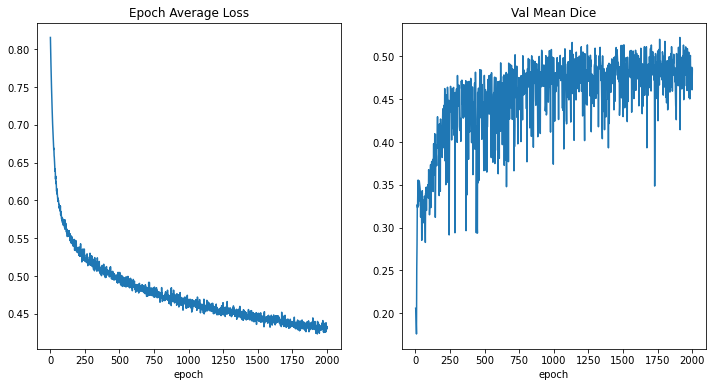

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/Image_262499828648_clean.mha


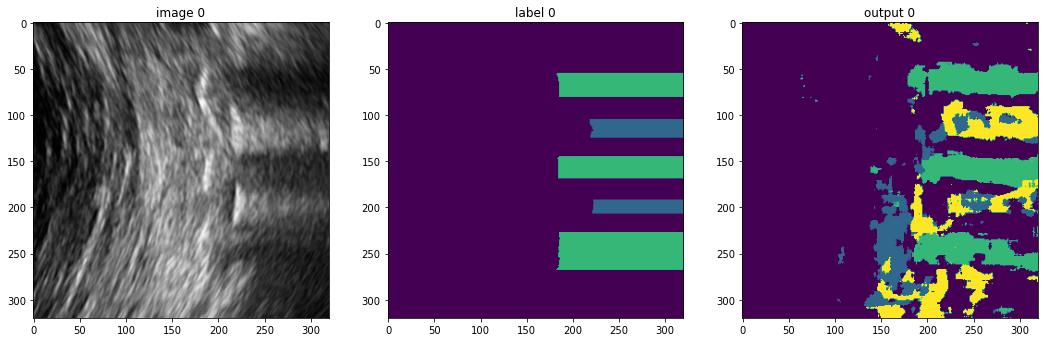

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_1087766719219_clean.mha


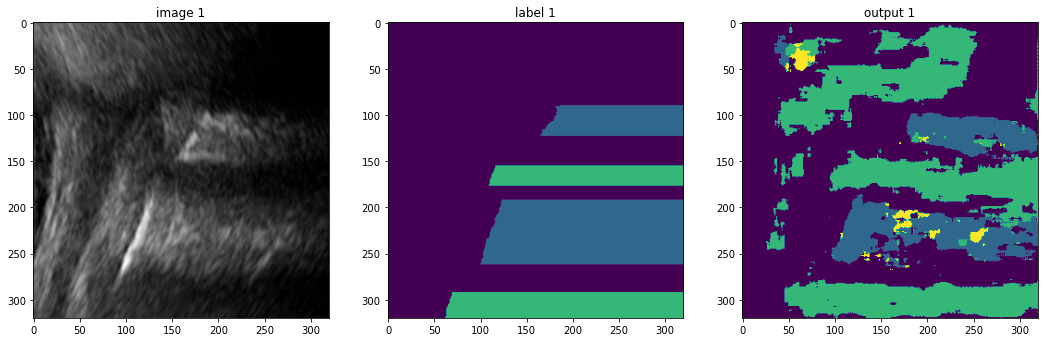

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_1404802450036_clean.mha


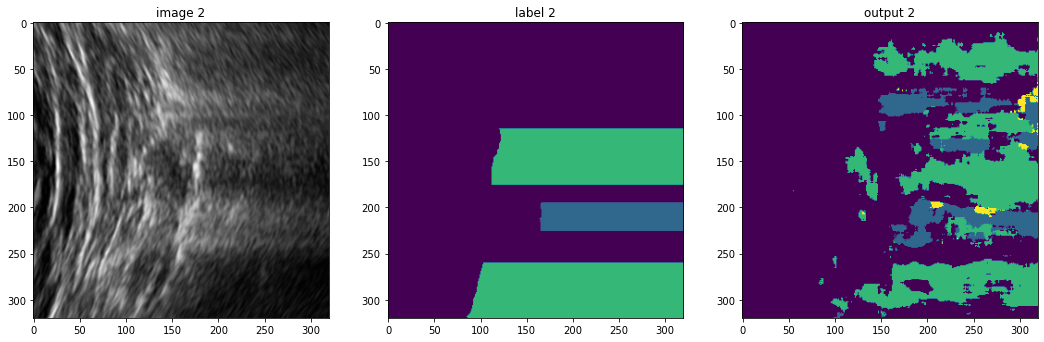

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_1749559540112_clean.mha


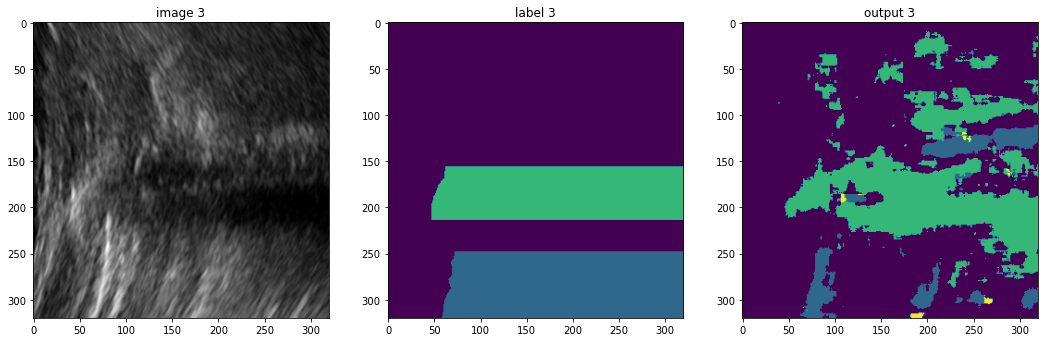

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_1895283541879_clean.mha


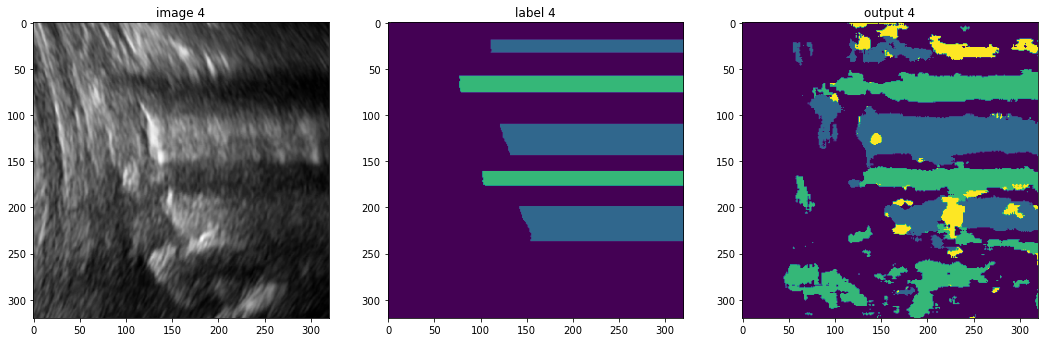

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_2454526567135_CLEAN.mha


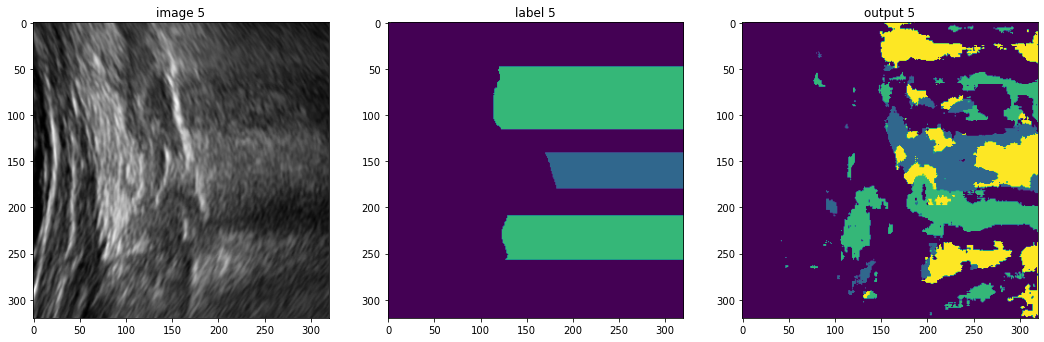

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_27180764486244_CLEAN.mha


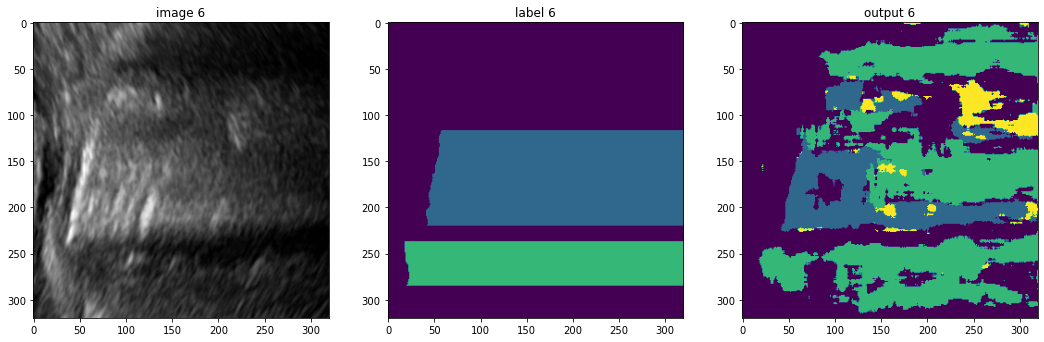

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_2734882394424_CLEAN.mha


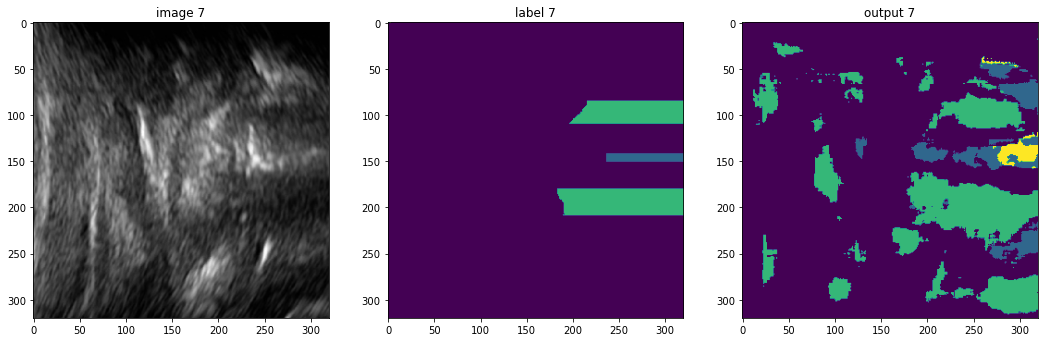

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_4641643404894_CLEAN.mha


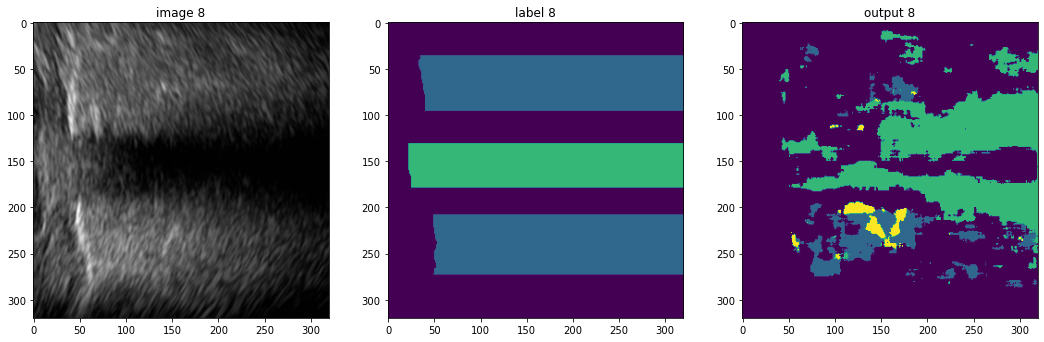

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_573611404207_CLEAN.mha


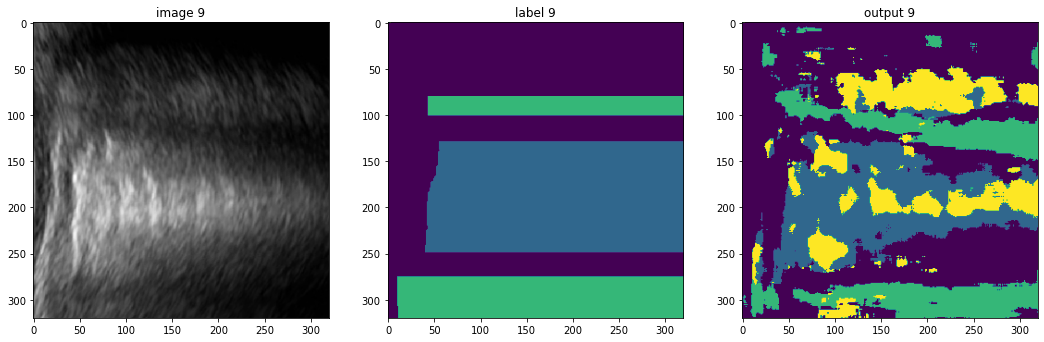

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_588695055398_clean.mha


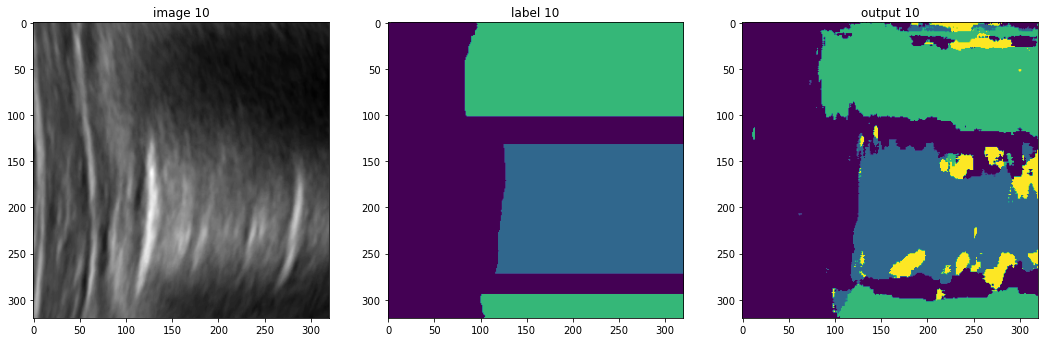

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_6056976176281_CLEAN.mha


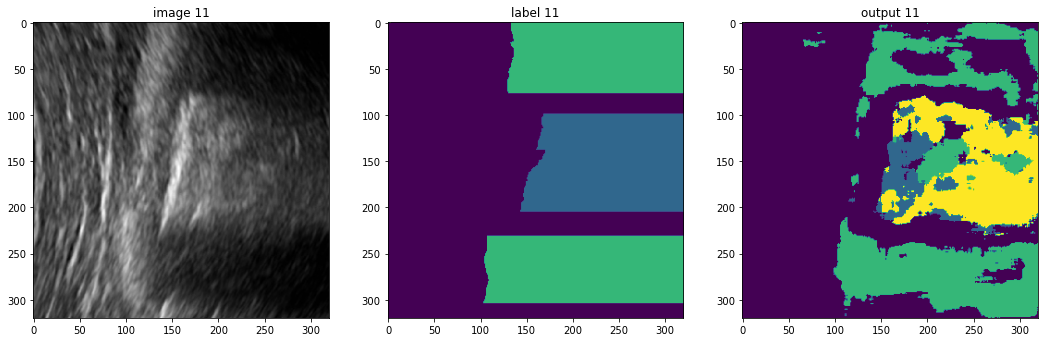

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_614587120545_clean.mha


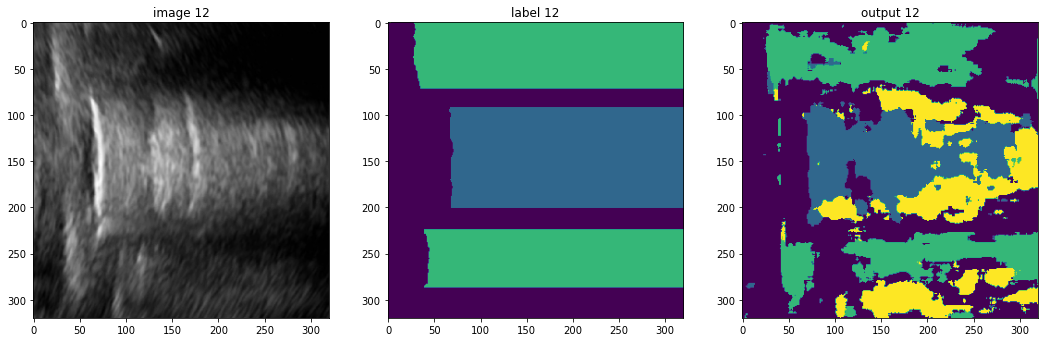

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_6370410622099_CLEAN.mha


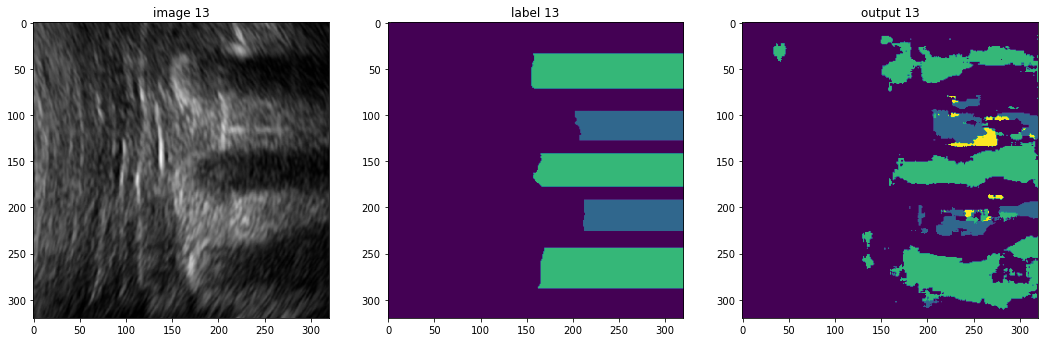

../../../Data/TrainingData/AR-UNet/BAMC-PTXSliding-Annotations-Linear/image_10391571128899_CLEAN.mha


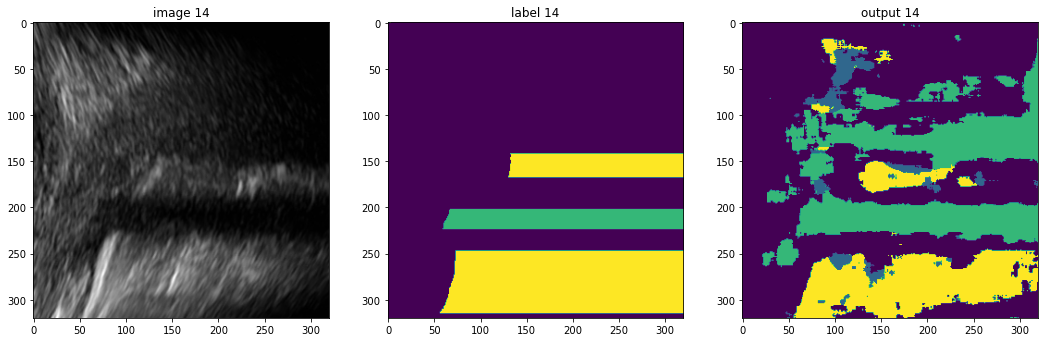

../../../Data/TrainingData/AR-UNet/BAMC-PTXSliding-Annotations-Linear/image_104932526155699_CLEAN.mha


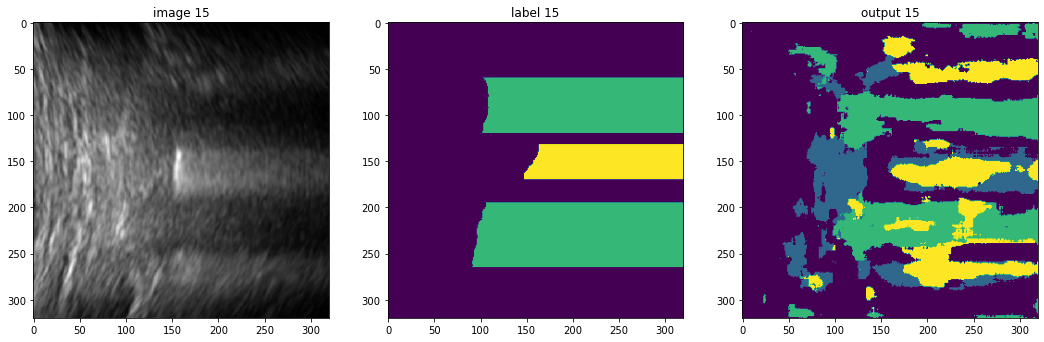

../../../Data/TrainingData/AR-UNet/BAMC-PTXSliding-Annotations-Linear/image_1327616672148_clean.mha


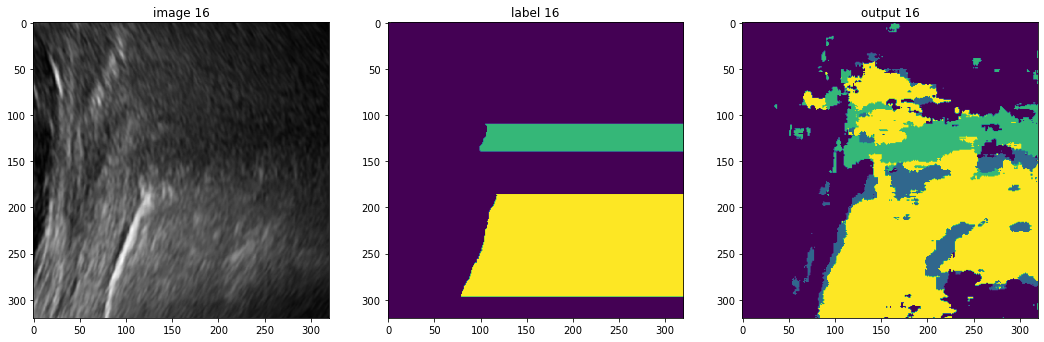

../../../Data/TrainingData/AR-UNet/BAMC-PTXSliding-Annotations-Linear/image_3315947589826_clean.mha


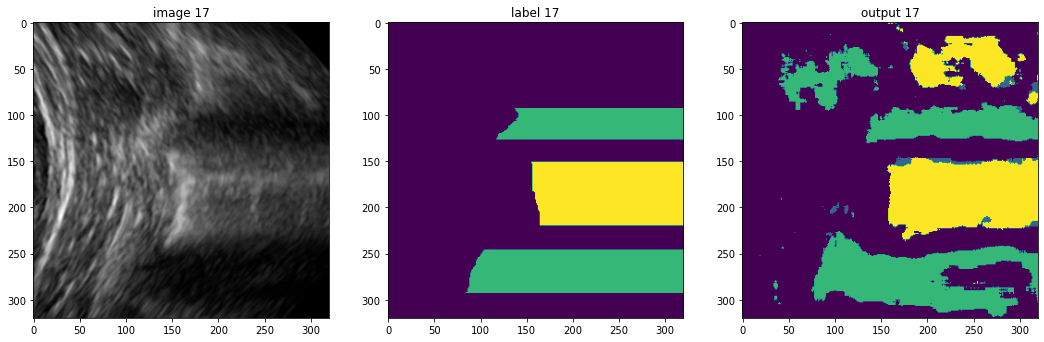

../../../Data/TrainingData/AR-UNet/BAMC-PTXSliding-Annotations-Linear/image_73815992352100_clean.mha


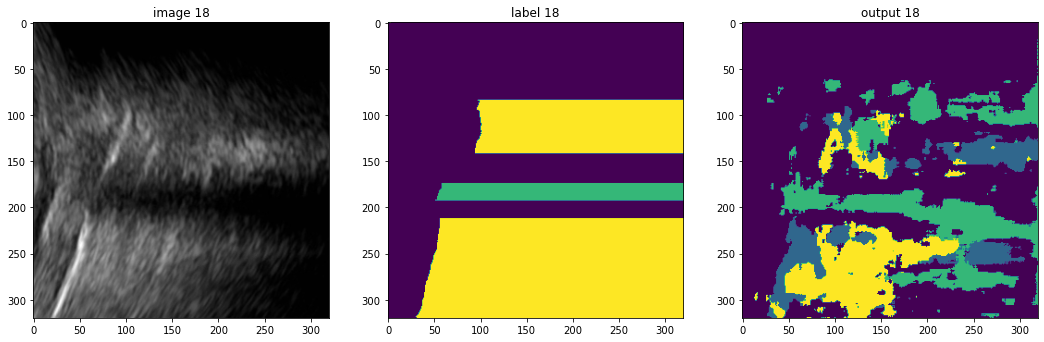

In [10]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "BAMC_PTX_3DUNet-4Class-Extruded.best_model.pth")))
model.eval()
with torch.no_grad():
    i = 0
    for b,val_data in enumerate(val_loader):
        roi_size = (320, 320, 48)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        for j in range(val_outputs.shape[0]):
            print(val_images[i])
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {i}")
            tmpV = val_data["image"][j, 0, :, :, 10]
            plt.imshow(tmpV, cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {i}")
            tmpV = val_data["label"][j, 0, :, :, 10]
            tmpV[0,0]=1
            tmpV[0,1]=2
            tmpV[0,2]=3
            plt.imshow(tmpV)
            plt.subplot(1, 3, 3)
            plt.title(f"output {i}")
            tmpV = torch.argmax(val_outputs, dim=1).detach().cpu()[j, :, :, 10]
            tmpV[0,0]=1
            tmpV[0,1]=2
            tmpV[0,2]=3
            plt.imshow(tmpV)
            plt.show()
            i += 1

## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=0)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=True, num_classes=4),
    AsDiscreted(keys="label", to_onehot=True, num_classes=4),
])

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "BAMC_PTX_3DUNet-2Class.best_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (320, 320, 48)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)